In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#import opencv
import cv2
import os

import imageio

In [2]:
import cv2
import os

def get_min_max_frames(video_folder_path):
    min_frames = float('inf')
    max_frames = 0

    # Loop through all files in the directory
    for video_file in os.listdir(video_folder_path):
        video_path = os.path.join(video_folder_path, video_file)
        
        # Ensure the file is a video
        if os.path.isfile(video_path) and video_file.endswith(('.mp4', '.avi', '.mov', '.mkv')):
            # Open the video using OpenCV
            video = cv2.VideoCapture(video_path)
            
            # Get the number of frames in the video
            frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
            
            # Update min and max frames
            if frames < min_frames:
                min_frames = frames
            if frames > max_frames:
                max_frames = frames
            
            # Release the video capture object
            video.release()
    
    # Return the min and max frame counts
    return min_frames, max_frames

# Example usage:
video_folder = 'Shop DataSet\shop lifters'
min_frames, max_frames = get_min_max_frames(video_folder)
print(f"Min frames: {min_frames}, Max frames: {max_frames}")


Min frames: 100, Max frames: 570


In [3]:
import cv2
import os

def get_min_max_frames(video_folder_path):
    min_frames = float('inf')
    max_frames = 0

    # Loop through all files in the directory
    for video_file in os.listdir(video_folder_path):
        video_path = os.path.join(video_folder_path, video_file)
        
        # Ensure the file is a video
        if os.path.isfile(video_path) and video_file.endswith(('.mp4', '.avi', '.mov', '.mkv')):
            # Open the video using OpenCV
            video = cv2.VideoCapture(video_path)
            
            # Get the number of frames in the video
            frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
            
            # Update min and max frames
            if frames < min_frames:
                min_frames = frames
            if frames > max_frames:
                max_frames = frames
            
            # Release the video capture object
            video.release()
    
    # Return the min and max frame counts
    return min_frames, max_frames

# Example usage:
video_folder = 'Shop DataSet/non shop lifters'
min_frames, max_frames = get_min_max_frames(video_folder)
print(f"Min frames: {min_frames}, Max frames: {max_frames}")


Min frames: 75, Max frames: 1850


# Load Data

In [2]:
def Frames_from_video_file(video_path, n_frames, output_size=(128, 128), frame_step=2):
    ''' 
    Creates frames from each video file present for each category.
    '''
    if not os.path.exists(video_path):
        print(f"Error: The video file at {video_path} does not exist.")
        return None

    result = []
    src = cv2.VideoCapture(video_path)

    if not src.isOpened():
        print(f"Error: Could not open video file {video_path}.")
        return None

    video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))

    if video_length == 0:
        print(f"Error: The video file {video_path} has no frames.")
        return None

    need_length = 1 + (n_frames - 1) * frame_step
    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = np.random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)

    # Read the first frame
    ret, frame = src.read()

    if ret and frame is not None:
        
        result.append(format_frames(frame, output_size))
    else:
        print(f"Warning: Could not read the first frame from {video_path}")
        return None

    # Read the remaining frames
    for i in range(n_frames - 1):
        for j in range(frame_step):
            ret, frame = src.read()
        if ret and frame is not None:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            print(f"Warning: Could not read frame at index {i} from {video_path}")
            result.append(np.zeros_like(result[0]))

    src.release()
    result = np.array(result)[..., [2, 1, 0]]  # Convert BGR to RGB
    #normalize 
    result = result / 255.0


    return result


In [3]:
def format_frames(frame,output_size):
    '''
    pad and resizes the frame

    args:
    frame: frame to be resized
    output_size: size of the output frame

    returns:
    resized and normalized frame
    '''
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

In [4]:
# Create a function to process all videos in a folder
def process_videos_from_folder(folder_path, label, n_frames, output_size=(224, 224), frame_step=2):
    video_data = []
    video_labels = []

    for video_file in os.listdir(folder_path):
        video_path = os.path.join(folder_path, video_file)
        
        # Check if the file is a video 
        if video_file.endswith(('.mp4', '.avi', '.mov')):
            # Extract frames from the video
            frames = Frames_from_video_file(video_path, n_frames, output_size, frame_step)
            
            # Append the frames and the label to the lists
            video_data.append(frames)
            video_labels.append(label)
    
    return np.array(video_data), np.array(video_labels)

In [5]:
shoplifting_folder = 'Shop DataSet/shop lifters'
non_shoplifting_folder = 'Shop DataSet/non shop lifters'

# Number of frames to extract from each video
n_frames = 25

# Extract frames from both folders
shoplifting_videos, shoplifting_labels = process_videos_from_folder(shoplifting_folder, label=1, n_frames=n_frames)
non_shoplifting_videos, non_shoplifting_labels = process_videos_from_folder(non_shoplifting_folder, label=0, n_frames=n_frames)

# Combine the data and labels from both categories
all_videos = np.concatenate([shoplifting_videos, non_shoplifting_videos], axis=0)
all_labels = np.concatenate([shoplifting_labels, non_shoplifting_labels], axis=0)

print(f'Total videos: {len(all_videos)}, Labels: {len(all_labels)}')

Total videos: 855, Labels: 855


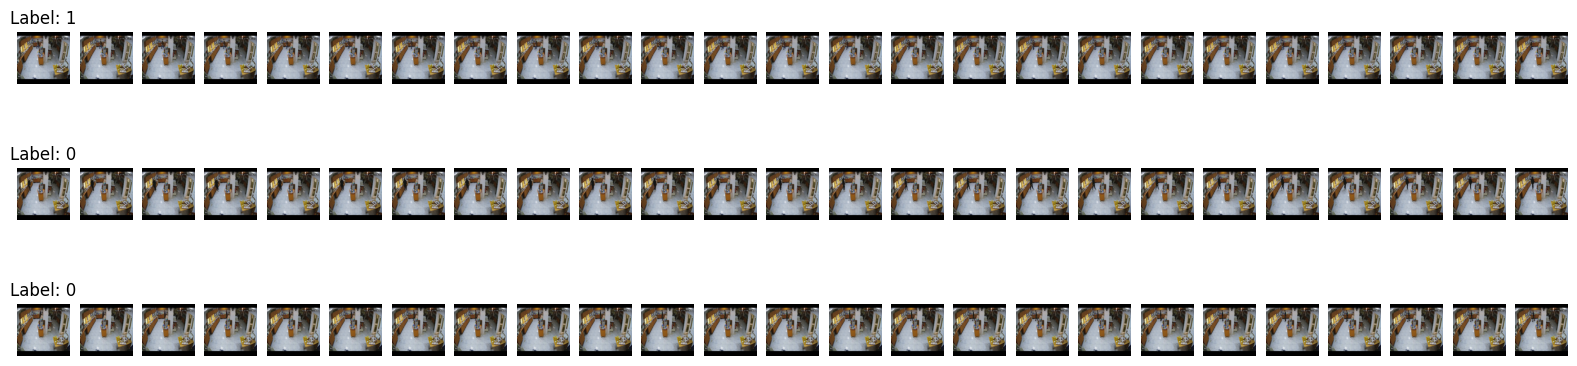

In [8]:

def plot_sample_frames(videos, labels, n_samples=3):
    ''' 
    Plot a sample of frames from the video dataset.
    
    Args:
    videos: list of video frames
    labels: corresponding labels
    n_samples: number of samples to plot
    '''
    fig, axs = plt.subplots(n_samples, n_frames, figsize=(20, 5))
    
    for i in range(n_samples):
        video_idx = np.random.randint(0, len(videos))
        for j in range(n_frames):
            axs[i, j].imshow(videos[video_idx][j])
            axs[i, j].axis('off')
        
        axs[i, 0].set_title(f'Label: {labels[video_idx]}')

    plt.show()

# Plot a sample of videos with their labels
plot_sample_frames(all_videos, all_labels)

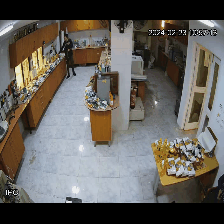

In [9]:
import imageio
import matplotlib.pyplot as plt
from IPython.display import Image, display

def to_gif(images):
    '''
    Creates GIF from the frames.

    Args:
    images: frames to be converted to gif.

    Returns:
    gif (displayed inline).
    '''
    
    # Convert images to the range [0, 255] and clip to ensure valid pixel values
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    
    # Calculate duration from fps (e.g., 10 fps -> 100 ms per frame)
    duration = 1000/ 10  # 10 fps
    
    # Save the GIF using duration instead of fps
    imageio.mimsave('./animation.gif', converted_images, duration=duration)  
    
    # Display the GIF
    display(Image(filename='./animation.gif'))

# Create a GIF from the first video frames
to_gif(all_videos[6])


In [6]:
# Print the shape of the first video in the 'all_videos' array
print(f"Shape of the first video: {all_videos[2].shape}")


Shape of the first video: (25, 224, 224, 3)


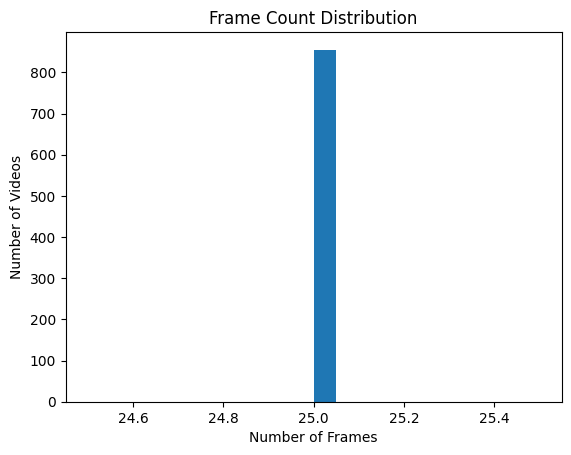

In [11]:
import matplotlib.pyplot as plt
frame_counts = [video.shape[0] for video in all_videos]
plt.hist(frame_counts, bins=20)
plt.title('Frame Count Distribution')
plt.xlabel('Number of Frames')
plt.ylabel('Number of Videos')
plt.show()


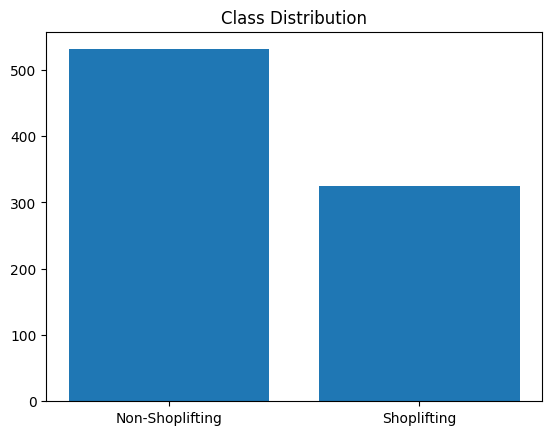

In [12]:
import numpy as np
unique, counts = np.unique(all_labels, return_counts=True)
plt.bar(unique, counts)
plt.xticks([0, 1], ['Non-Shoplifting', 'Shoplifting'])
plt.title('Class Distribution')
plt.show()


# Split Data

In [7]:
from sklearn.model_selection import train_test_split
# First, split into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(all_videos, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

# Further split the training data into training and validation sets 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


# Model 
CNN & RNN


In [8]:
from tensorflow.keras import layers, models
def build_custom_cnn(input_shape):
    model = models.Sequential()

    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output
    model.add(layers.Flatten())
    
    return model


In [9]:
def build_cnn_rnn_model(n_frames, frame_height, frame_width, channels, n_classes):
    # Define input shape for videos (sequence of frames)
    video_input = layers.Input(shape=(n_frames, frame_height, frame_width, channels))

    # TimeDistributed CNN
    cnn_model = build_custom_cnn((frame_height, frame_width, channels))
    cnn_features = layers.TimeDistributed(cnn_model)(video_input)

    # Add an LSTM layer to capture temporal relationships
    rnn_output = layers.LSTM(64, return_sequences=False)(cnn_features)

    # Fully Connected Layers for classification
    dense = layers.Dense(64, activation='relu')(rnn_output)
    output = layers.Dense(n_classes, activation='softmax')(dense)

    # Combine everything into a model
    model = models.Model(inputs=video_input, outputs=output)
    return model


In [10]:
cnn_rnn_model = build_cnn_rnn_model(n_frames=25, frame_height=224, frame_width=224, channels=3, n_classes=2)
cnn_rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_rnn_model.summary()


c:\Users\hazem\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 25, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 25, 86528)      │        93,248 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │    22,167,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,265,346 (84.94 MB)

 Trainable params: 22,265,346 (84.94 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Callbacks early stoping and learning rate reduction
callbacks = [
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
]


In [12]:
# Train the model with validation
history = cnn_rnn_model.fit(
    X_train, y_train,
    epochs=20,  
    batch_size=8,  
    validation_data=(X_val, y_val)  
)

Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 329s 4s/step - accuracy: 0.5509 - loss: 0.6904 - val_accuracy: 0.6204 - val_loss: 0.6657
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 317s 5s/step - accuracy: 0.6287 - loss: 0.6664 - val_accuracy: 0.6204 - val_loss: 0.6685
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 323s 5s/step - accuracy: 0.6125 - loss: 0.6701 - val_accuracy: 0.6204 - val_loss: 0.6639
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 332s 5s/step - accuracy: 0.6347 - loss: 0.6642 - val_accuracy: 0.6204 - val_loss: 0.6647
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 337s 5s/step - accuracy: 0.6350 - loss: 0.6580 - val_accuracy: 0.6204 - val_loss: 0.6660
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 334s 5s/step - accuracy: 0.6283 - loss: 0.6618 - val_accuracy: 0.6204 - val_loss: 0.6664
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 335s 5s/step - accuracy: 0.6458 - loss: 0.6574 - val_accuracy: 0.6204 - val_loss: 0.6676
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 341s 5s/step - accuracy: 0.5644 - loss: 0.6850 - val_accuracy: 0.6204 - v

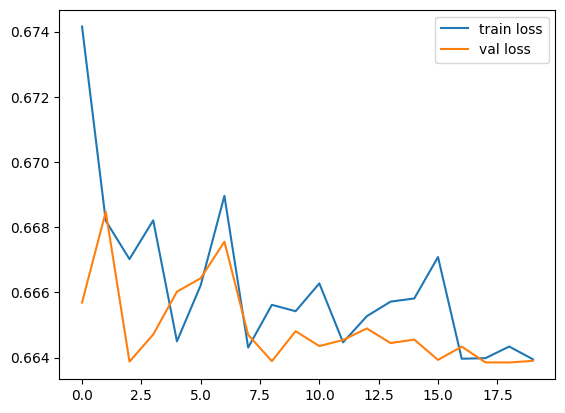

In [13]:
#plot loss 
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()


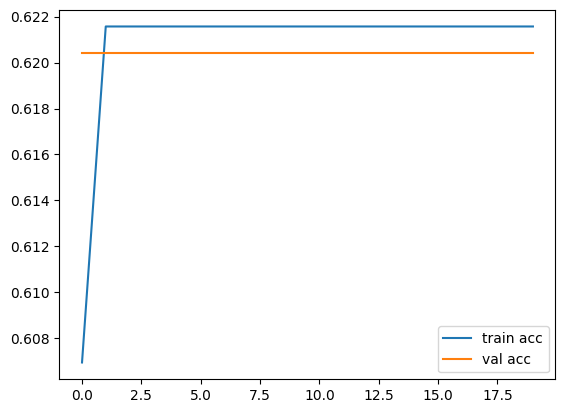

In [14]:
#plot accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [15]:
# save model
cnn_rnn_model.save('shoplifting_detection_model.h5')